In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pyproj

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt


In [3]:
dateparse = lambda dates: [pd.datetime.strptime(d, '%d/%m/%Y') for d in dates]

#read in the ACT Pedestrian Crash Data (with custom fades)
act_data = []
act_data = pd.read_csv('Cyclist_Crashes_Fades.csv',parse_dates=['CrashDate'], date_parser=dateparse)
act_data['CasScale'] = act_data.Casualties + 1

In [4]:
#display the first 5 entries

act_data.head()

,CrashID,CRASH_DATE_TEXT,Year,Day,Month,CrashDate,DayNumber,CrashTime,Severity,SevIndex,...,Fad1804,Fad1805,Fad1806,Fad1807,Fad1808,Fad1809,Fad1810,Fad1811,Fad1812,CasScale
0,1055714,20 February 2013,2013,20,2,2013-02-20,416,7:57,Injury,0.7,...,0.037332,0.035466,0.033635,0.031953,0.030303,0.028739,0.027302,0.025893,0.024598,2
1,1083381,17 March 2014,2014,17,3,2014-03-17,806,7:30,Injury,0.7,...,0.072724,0.069088,0.065521,0.062245,0.059032,0.055984,0.053185,0.050440,0.047918,2
2,1025046,04 January 2012,2012,4,1,2012-01-04,3,8:50,Property Damage Only,0.1,...,0.000274,0.000246,0.000221,0.000199,0.000178,0.000160,0.000144,0.000129,0.000116,1
3,1107433,07 April 2015,2015,7,4,2015-04-07,1192,8:05,Property Damage Only,0.1,...,0.017805,0.016024,0.014371,0.012934,0.011600,0.010403,0.009363,0.008397,0.007557,1
4,1036447,10 June 2012,2012,10,6,2012-06-10,161,16:30,Property Damage Only,0.1,...,0.000476,0.000429,0.000385,0.000346,0.000310,0.000278,0.000251,0.000225,0.000202,1


In [144]:
#Tidy up the column names

act_data = act_data.rename(index=str, columns={
    "Crash Date": "CrashDate",
    "Crash ID": "CrashID",
    "Crash Time": "CrashTime",
    "Crash Type": "CrashType",
    "Pedestrian Casualties": "Casualties",
    "Reported Location": "ReportedLocation"})

In [5]:
#Pull the coordinates out into a list of tuples for conversion
#from longtitude/latitude to GDA94 / MGA zone 55 projection

zipped_coordinates = list(zip(act_data['Long'], act_data['Latt']))

zipped_coordinates[0:5]

[(149.13335800000002, -35.253575),
 (149.129453, -35.277134999999994),
 (149.129771, -35.275784),
 (149.133364, -35.252917),
 (149.13394399999999, -35.185382000000004)]

In [6]:
#Convert into a new list of tuples

epsg4326 = pyproj.Proj(init='epsg:4326')
epsg28355 = pyproj.Proj(init='epsg:28355')

convert_coordinates = []

for x, y in zipped_coordinates:
    convert_coordinates.append(pyproj.transform(epsg4326,epsg28355,x,y))
    
convert_coordinates[:5]


[(694085.0720773041, 6096749.696336439),
 (693673.648513112, 6094143.893597912),
 (693705.7937165676, 6094293.134732151),
 (694087.1873954628, 6096822.674373025),
 (694300.9453080008, 6104312.939378696)]

In [8]:
#create crs variable for GeoDataFrame

crs = {'init': 'epsg:28355'}

# save the minimum and maximum coordinates for use 
# in limiting the axes - as we plot roads (larger) as well as pedestrian
# crash incidents
min_x = min([x for x,y in convert_coordinates])
min_y = min([y for x,y in convert_coordinates])
max_x = max([x for x,y in convert_coordinates])
max_y = max([y for x,y in convert_coordinates])

In [9]:
#create geometry variable for GeoDataFrame

geometry = [Point(x, y) for x, y in convert_coordinates]

geometry[0:5]

In [10]:
#create GeoDataFrame
act_geo_df = gpd.GeoDataFrame(act_data, crs=crs, geometry=geometry)

compare_date = datetime.datetime(2012,3,1,0,0,0)
#act_geo_df.head()
act_geo_filt = act_geo_df[act_geo_df.CrashDate < compare_date]
#   act_geo_df.query('CrashDate < "d(2012-03-01)"') 
act_geo_filt.head()

,CrashID,CRASH_DATE_TEXT,Year,Day,Month,CrashDate,DayNumber,CrashTime,Severity,SevIndex,...,Fad1805,Fad1806,Fad1807,Fad1808,Fad1809,Fad1810,Fad1811,Fad1812,CasScale,geometry
2,1025046,04 January 2012,2012,4,1,2012-01-04,3,8:50,Property Damage Only,0.1,...,0.000246,0.000221,0.000199,0.000178,0.000160,0.000144,0.000129,0.000116,1,POINT (693705.7937165676 6094293.134732151)
6,1027295,03 February 2012,2012,3,2,2012-02-03,33,5:50,Injury,0.7,...,0.018425,0.017474,0.016600,0.015743,0.014931,0.014184,0.013452,0.012779,2,POINT (692212.9025408704 6089489.23344312)
16,1039424,15 January 2012,2012,15,1,2012-01-15,14,19:20,Property Damage Only,0.1,...,0.000256,0.000229,0.000207,0.000185,0.000166,0.000150,0.000134,0.000121,1,POINT (690361.0570450404 6098924.759653772)
54,1026065,06 January 2012,2012,6,1,2012-01-06,5,9:30,Property Damage Only,0.1,...,0.000248,0.000222,0.000200,0.000179,0.000161,0.000145,0.000130,0.000117,1,POINT (685244.5296753977 6103269.647358468)
70,1048301,01 February 2012,2012,1,2,2012-02-01,31,18:15,Property Damage Only,0.1,...,0.000272,0.000244,0.000219,0.000197,0.000176,0.000159,0.000142,0.000128,1,POINT (689350.3159514666 6087418.258889241)


In [11]:
act_geo_df.query('SevIndex == 1')

,CrashID,CRASH_DATE_TEXT,Year,Day,Month,CrashDate,DayNumber,CrashTime,Severity,SevIndex,...,Fad1805,Fad1806,Fad1807,Fad1808,Fad1809,Fad1810,Fad1811,Fad1812,CasScale,geometry
123,1054837,22 September 2012,2012,22,9,2012-09-22,265,18:10,Fatal,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,POINT (688199.5651072051 6100981.656137784)
235,1080020,11 February 2014,2014,11,2,2014-02-11,772,18:20,Fatal,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,POINT (694515.4509110376 6093995.931757599)
659,1130702,29 January 2015,2015,29,1,2015-01-29,1124,7:30,Fatal,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,POINT (690740.7344995146 6089668.358418825)
808,1156062,31 March 2017,2017,31,3,2017-03-31,1916,6:25,Fatal,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,POINT (693345.70519553 6061706.454387363)
1086,1191323,07 April 2018,2018,7,4,2018-04-07,2288,9:05,Fatal,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,POINT (689805.1558572976 6074881.204549422)


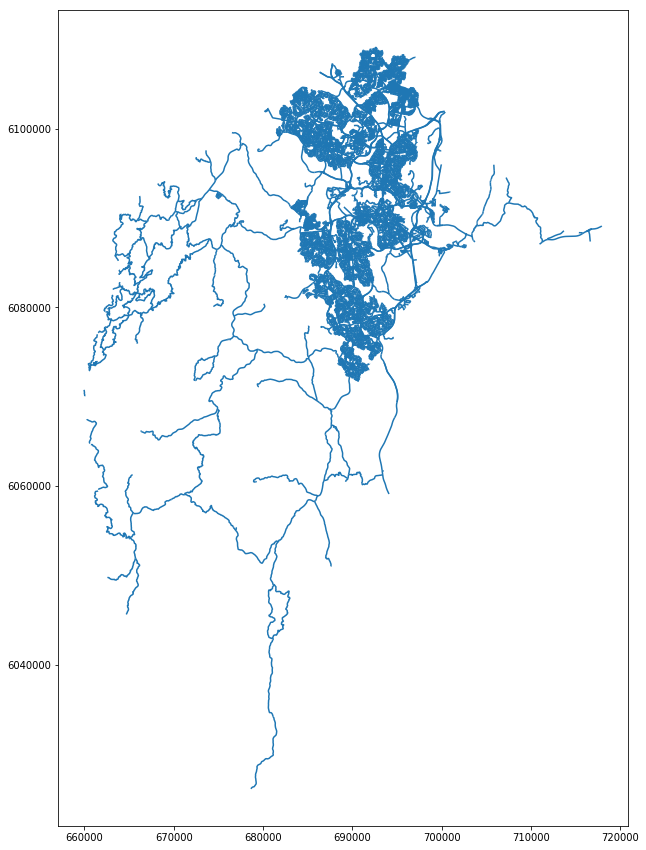

In [12]:
#read in the ACT shapemap

ACT_map_district = gpd.read_file('ACT_data/ACT_Road_Centrelines.shp')

fig,ax = plt.subplots(figsize = (15,15))
ACT_map_district.plot(ax = ax)

<Figure size 432x288 with 0 Axes>

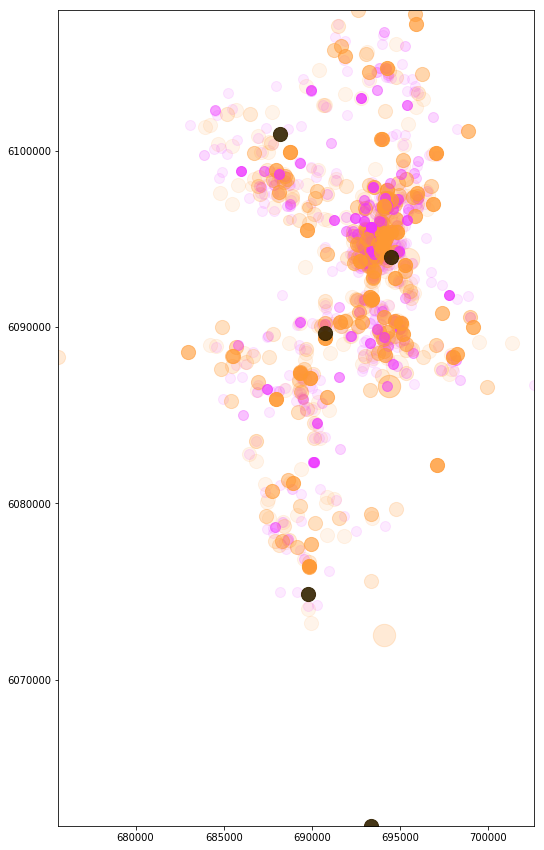

In [17]:
def alphaQuery(year,month,alpha,delta=0.1):
    yy = f'{year - 2000:02}'
    mm = f'{month:02}'
    fad = 'Fad'+yy+mm
    return fad + ' <= ' + str(alpha) + ' and ' + fad + ' > ' + str(alpha - delta) + ')'

def alphaQuery2(year,month,sev,alpha,delta=0.1):
    yy = f'{year - 2000:02}'
    mm = f'{month:02}'
    fad = 'Fad'+yy+mm
    return 'Severity == "' + sev + '" and ' + \
           fad + ' <= ' + str(alpha) + ' and ' + fad + ' > ' + str(alpha - delta) + ')'

def alphaQuery3(year,month,sevIndex,casualties,alpha,delta=0.1):
    yy = f'{year - 2000:02}'
    mm = f'{month:02}'
    fad = 'Fad'+yy+mm
    if (sevIndex == 1):
        return '(SevIndex == ' + str(sevIndex) + ' and Casualties == ' + str(casualties) + ')'' and (' + \
               fad + ' == 1)'
    else:
        return '(SevIndex == ' + str(sevIndex) + ' and Casualties == ' + str(casualties) + ') and (' + \
               fad + ' <= ' + str(alpha) + ' and ' + fad + ' > ' + str(alpha - delta) + ')'

def plot_yearMonthAlpha(df,ax1,year,month,sev,alpha,colour):
    for casualties in range(0,3):
        markersize = 100 + casualties * casualties * 100
        qr = df.query(alphaQuery3(year,month,sev,casualties,alpha,0.1))
        if qr.size > 0:
            qr.plot(
                ax=ax1, 
                markersize=markersize,
                color=colour,
                alpha=alpha)

#Plot the public pedestrian crash data onto the map, and do some styling
def print_plot_ymd(df, ax1, year, month, day, fileprefix, seq):

#    fig,ax = plt.subplots(figsize=(30,30))
#ACT_map_district.plot(ax=ax, alpha=0.5, color='grey')
#act_geo_df.query('Year <= 2012 and Month < 6').plot(
    yy = f'{year - 2000:02}'
    mm = f'{month:02}'
    dd = f'{day:02}'
    sn = f'{seq:05}'
    filename = fileprefix + sn + '.png'
    i_colour = "#FF9933" # '#FF9900'
    p_colour = "#EE33FF"
    f_colour = "#332200"
    compare_date = datetime.datetime(year,month,day,0,0,0)
    #act_geo_df.head()
    df_filt = df[df.CrashDate < compare_date]

    for alpha in np.arange(0.1,1.0,0.1):
        plot_yearMonthAlpha(df_filt,ax1,year,month,0.7,alpha,i_colour)
        plot_yearMonthAlpha(df_filt,ax1,year,month,0.1,alpha,p_colour)
    plot_yearMonthAlpha(df_filt,ax1,year,month,1,alpha,f_colour)
    plt.savefig(filename,bbox_inches='tight',transparent=True)

        
#plt.clf()
#fig,ax = plt.subplots(figsize=(30,30))
#ax.set_xlim(left=min_x, right=max_x)
#ax.set_ylim(bottom=min_y, top=max_y)

# plot all pedestrian accidents - small blue dots
#act_geo_df.plot(
#    ax=ax, 
#    markersize=50,
#    color="#00FFFF")

#bounding_box = act_geo_df.envelope
#bb_df = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])

#ACT_map_district = gpd.read_file('ACT_data/ACT_Road_Centrelines.shp')
#intersections = gpd.overlay(bb_df, ACT_map_district, how='intersection')
#ACT_map_district.plot(ax=ax, alpha=0.5, color='grey')
#plot_yearMonthAlpha(act_geo_df,2014,6,1,"#FF9900")


#print_plot_ymd(act_geo_df,ax,2014,6,1,"test_ped_crash_",1)
#alphaQuery3(2014,6,0.7,1,0.5,0.1)

def print_act_map(df,fileprefix):
    filename = fileprefix + 'basemap.png'
    plt.clf()
    fig,ax = plt.subplots(figsize=(15,15))
    ax.set_xlim(left=min_x, right=max_x)
    ax.set_ylim(bottom=min_y, top=max_y)
    df.plot(ax=ax, alpha=0.5, color='grey')
    plt.savefig(filename,bbox_inches='tight',transparent=False)


def print_frames(df, fileprefix):
    frame_no = 0
    # plot all pedestrian accidents - small blue dots
    #act_geo_df.plot(
    #    ax=ax, 
    #    markersize=50,
    #    color="#00FFFF")

    #bounding_box = act_geo_df.envelope
    #bb_df = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])

    #ACT_map_district = gpd.read_file('ACT_data/ACT_Road_Centrelines.shp')
    #intersections = gpd.overlay(bb_df, ACT_map_district, how='intersection')
    for year in range(2012,2019):
        for month in range(1,13):
            for day in range(2,28,2):
                plt.close()
                plt.clf()
                fig,ax = plt.subplots(figsize=(15,15))
                ax.set_xlim(left=min_x, right=max_x)
                ax.set_ylim(bottom=min_y, top=max_y)
                #ACT_map_district.plot(ax=ax, alpha=0.5, color='grey')
                print_plot_ymd(df,ax,year,month,day,fileprefix,frame_no)
                frame_no += 1

fileprefix = "./images/cycle_crash_"
# Print out the ACT street map - to be used as a background                
print_act_map(ACT_map_district, fileprefix)
# Print out the frames for the animation
print_frames(act_geo_df, fileprefix)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/mapclassify/classifiers.py:95: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/mapclassify/classifiers.py:96: UserWarning: Warning: setting k to 3
  Warn('Warning: setting k to %d' % k_q, UserWarning)


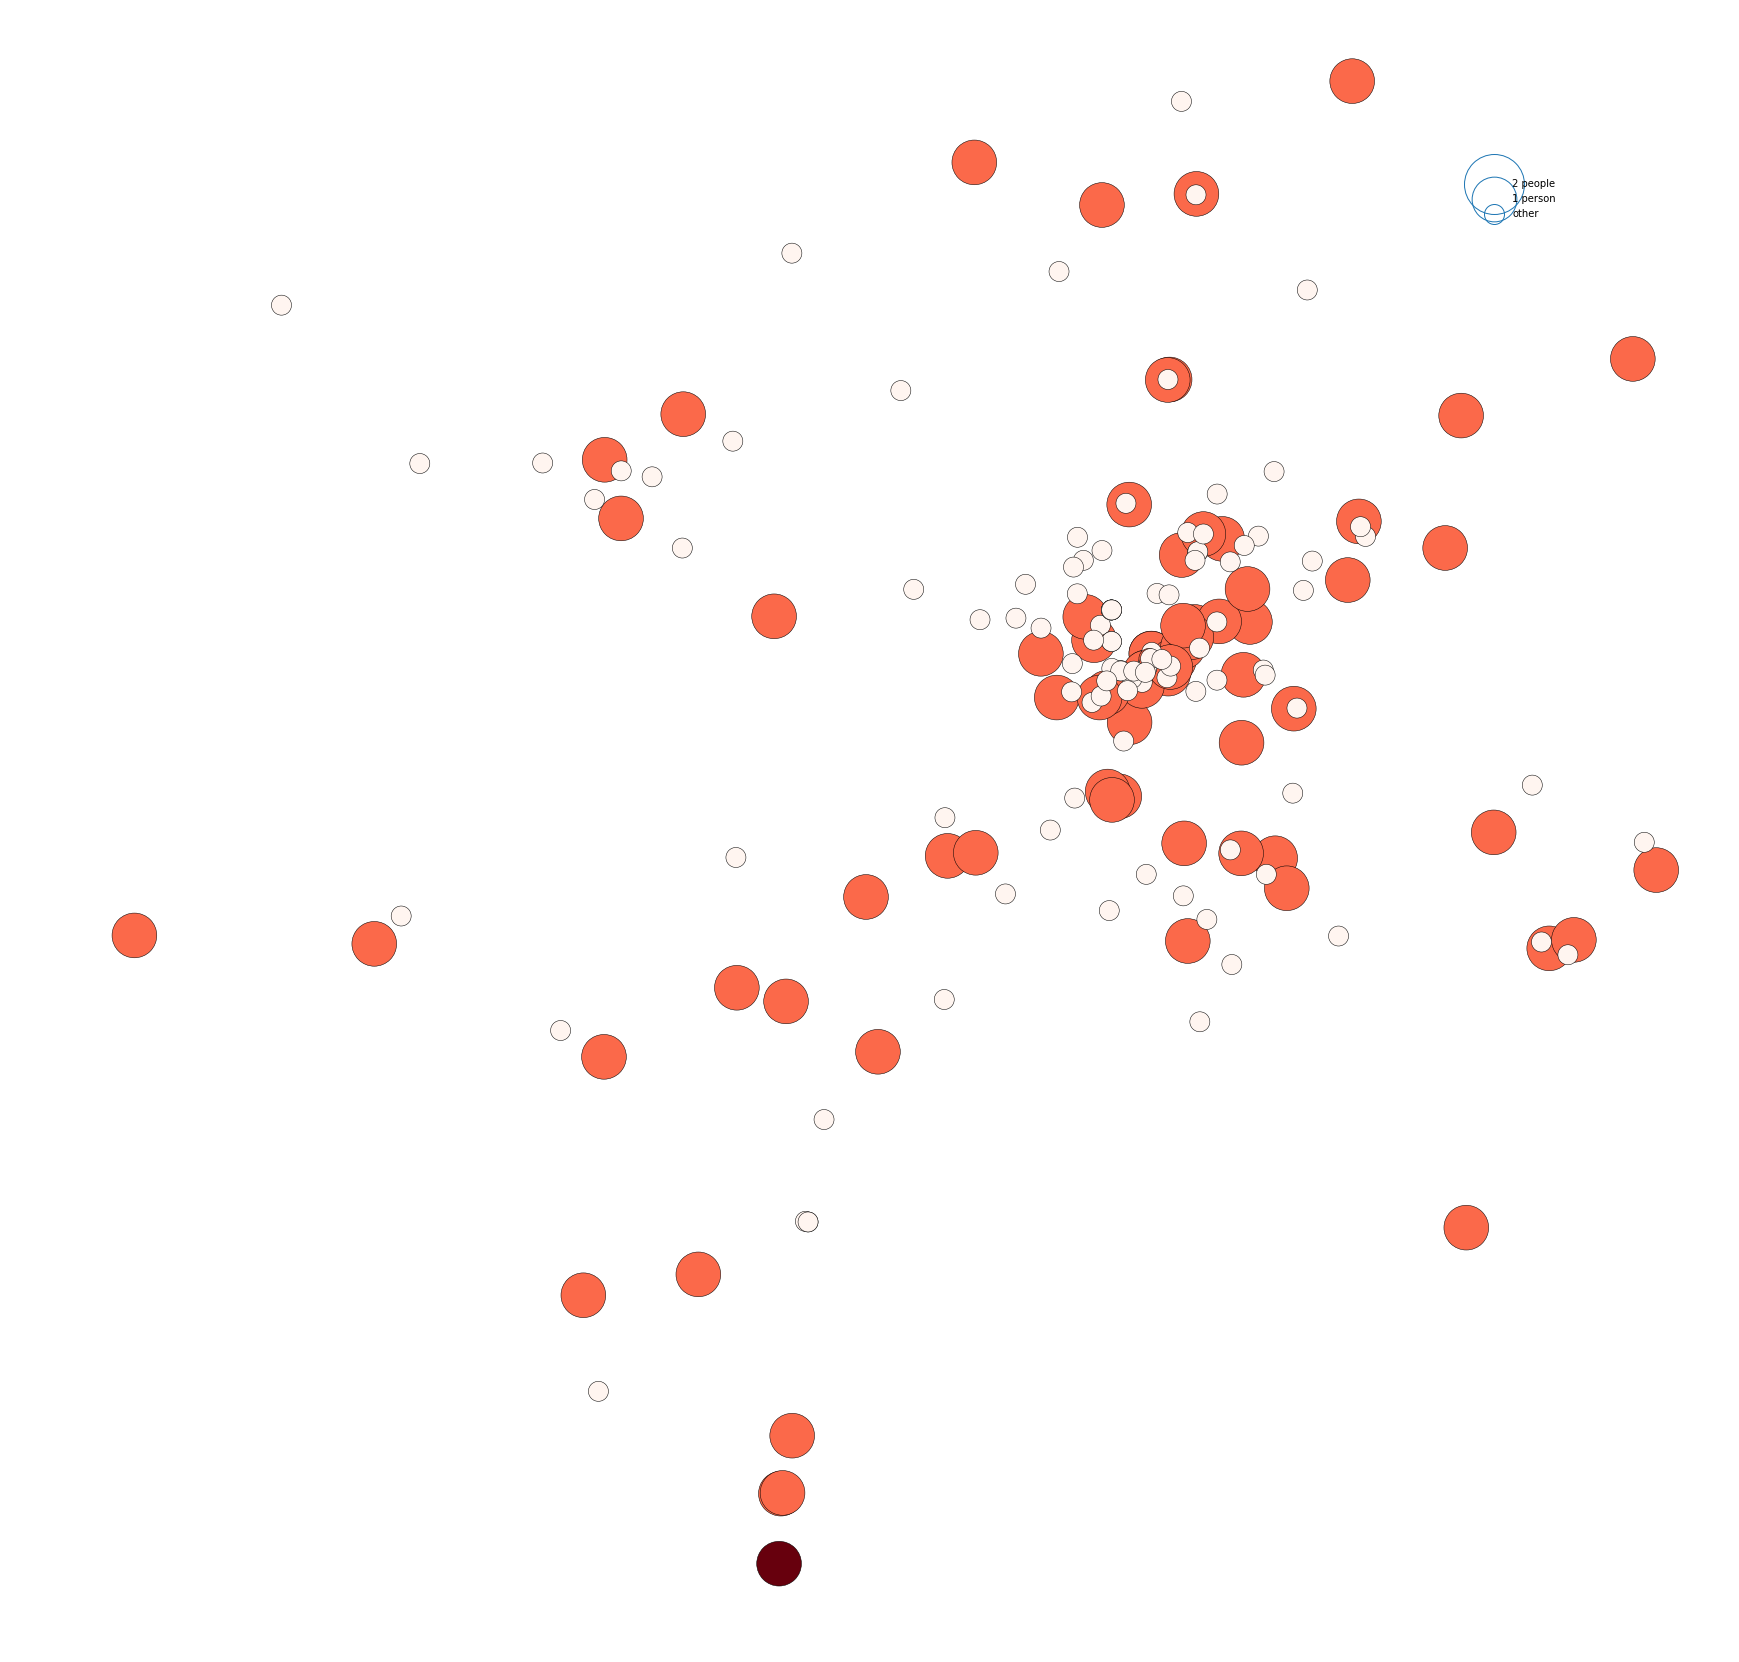

In [16]:
# Plot the figure.
fig,ax = plt.subplots(figsize=(30,30))
point_kwargs = {'linewidth': 0.5, 'edgecolor': 'black'}
legend_kwargs = {'bbox_to_anchor': (0.9, 0.9), 'frameon': False}
poly_kwargs = {'linewidth': 0.5, 'edgecolor': 'gray', 'zorder': -1}
#ax = gplt.polyplot(ACT_map_district,
#                   projection=gcrs.AlbersEqualArea(central_longitude=149, central_latitude=-35),
#                   **poly_kwargs)
#act_geo_fatal = act_geo_df.query('Severity == "Fatal"') 
gplt.pointplot(act_geo_df.query('Year == 2018'),ax=ax,
              scale='CasScale',limits=(20,100),
              #projection=gcrs.AlbersEqualArea(),
              hue='SevIndex', cmap='Reds',
              legend=True,legend_var='scale',legend_values=[3,2,1],legend_labels=['2 people','1 person','other'],
              legend_kwargs=legend_kwargs,
               **point_kwargs)

In [36]:
!pip install mapclassify